<a href="https://colab.research.google.com/github/cyamax/time_series_forecast_lab/blob/main/Darts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dartsのチュートリアルを試す

公式のDartsのチュートリアル  
https://unit8co.github.io/darts/examples/darts-intro.html

## Dartsの準備

In [1]:
# サイズが大きいライブラリのため、時間がかかる。
!pip install 'u8darts[all]'

     |████████████████████████████████| 133kB 5.2MB/s 
     |████████████████████████████████| 25.9MB 1.5MB/s 
     |████████████████████████████████| 112kB 55.6MB/s 
     |████████████████████████████████| 6.8MB 51.4MB/s 
     |████████████████████████████████| 8.7MB 12.2MB/s 
     |████████████████████████████████| 71kB 7.9MB/s 
     |████████████████████████████████| 14.6MB 352kB/s 
     |████████████████████████████████| 788kB 45.9MB/s 
     |████████████████████████████████| 10.5MB 36.6MB/s 
     |████████████████████████████████| 61kB 6.0MB/s 
     |████████████████████████████████| 1.5MB 42.8MB/s 
     |████████████████████████████████| 3.0MB 60.4MB/s 
     |████████████████████████████████| 753.2MB 26kB/s 
     |████████████████████████████████| 358kB 54.5MB/s 
  Created wheel for holidays: filename=holidays-0.10.2-cp36-none-any.whl size=111560 sha256=10df82720f4b59463b800d3037c48114d9a2dfbb38430fc5160a7759ff41e407
  Stored in directory: /root/.cache/pip/wheels/68/55/29/95836cc

In [10]:
!wget https://raw.githubusercontent.com/unit8co/darts/master/examples/AirPassengers.csv

--2020-11-06 14:28:18--  https://raw.githubusercontent.com/unit8co/darts/master/examples/AirPassengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1746 (1.7K) [text/plain]
Saving to: ‘AirPassengers.csv.1’

AirPassengers.csv.1 100%[===================>]   1.71K  --.-KB/s    in 0s      

2020-11-06 14:28:18 (35.3 MB/s) - ‘AirPassengers.csv.1’ saved [1746/1746]



In [11]:
%load_ext autoreload
#python実行時に毎回モジュールをリロードする
%autoreload 2
# matplotlibでは、plt.showを呼ぶと描画を行う。ただし、inline指定の場合、plt.showを省略可能
%matplotlib inline 

import sys
import pandas as pd
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    StandardRegressionModel,
    Theta,
    FFT
)
from darts.metrics import mape, mase
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis

import warnings
# warnings.filterwarnings("ignore") 
import logging
logging.disable(logging.CRITICAL)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


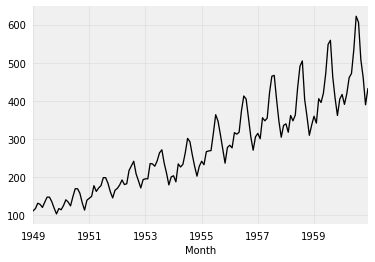

In [12]:
df = pd.read_csv('AirPassengers.csv', delimiter=",")
series = TimeSeries.from_dataframe(df, 'Month', ['#Passengers'])

series.plot()

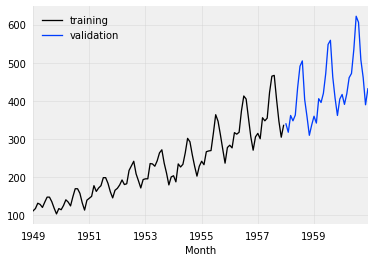

In [13]:
train, val = series.split_before(pd.Timestamp('19580101'))
train.plot(label='training')
val.plot(label='validation')
plt.legend();

NaiveSeasonalをK=1にすることで、Kステップ前に発生した値を繰り返す。

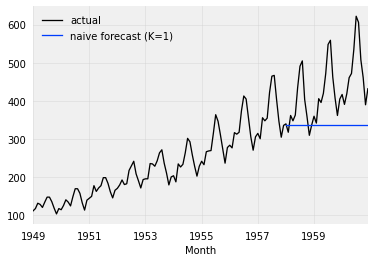

In [22]:
naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(36)

series.plot(label='actual')
naive_forecast.plot(label='naive forecast (K=1)')
plt.legend();

K=12で過去12ヶ月分のデータを繰り返す

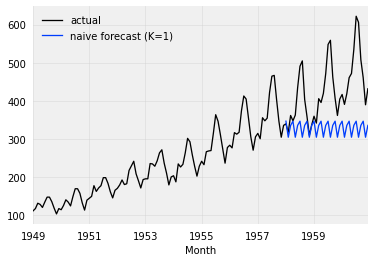

In [25]:
naive_model = NaiveSeasonal(K=3)
naive_model.fit(train)
naive_forecast = naive_model.predict(36)

series.plot(label='actual')
naive_forecast.plot(label='naive forecast (K=1)')
plt.legend();

適切な周期がわからないので、自己相関係数(ACF、コレログラム)を調べてラグを強調することで確認できる。
下の図の例では、12ヶ月のところで線が長くなっている。
0ヶ月のところが1.0になっているのは今の自分と今の自分をひかくしているので当然同じ(＝１)となる。
アルファ=0.05は信頼区間。青いところを超えている部分は統計的に有意差がある（＝偶然発生したわけではなく、意味がある現象）ということ。

また、ここでは自己相関係数であることに注意。（≠偏自己相関係数ではない）


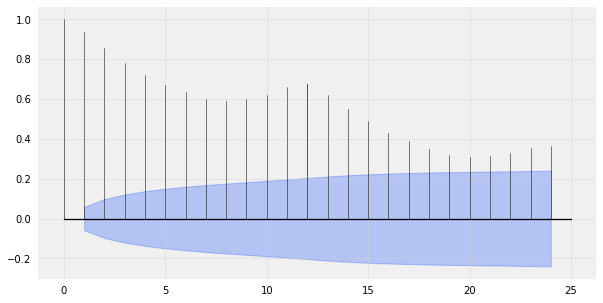

In [31]:
plot_acf(train, m = 12,alpha=0.05)

今日の値は３日前の値と２日前と１日前の値の和とも考えられる。そうすると自己相関は純粋な相関ではないことがわかる。
今の自分と３日前の自分を１，２日前の抜いて相関を計算するのが偏自己相関(PACF)。
Dartsにはpacfはなさそう？

for文で季節の候補を探す事もできる。

In [34]:
for m in range(2, 25):
    # alphaは信頼区間の水準。上図の青い部分。設定は信頼区間=5%
    is_seasonal, period = check_seasonality(train, m=m, alpha=.05)
    if is_seasonal:
        print('There is seasonality of order {}.'.format(period))

There is seasonality of order 12.


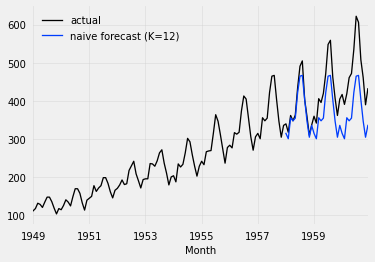

In [9]:
seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(36)

series.plot(label='actual')
seasonal_forecast.plot(label='naive forecast (K=12)')
plt.legend();

In [9]:
季節性は発見できたが、トレンド成分が反映されていない。
トレンドを見つけるモデルはNaiveDraft。

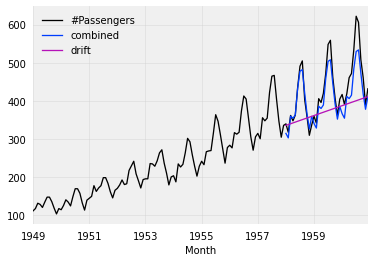

In [35]:
drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(36)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label='combined')
drift_forecast.plot(label='drift')
plt.legend();